In [1]:
from dataclasses import dataclass
import pandas as pd
import torch
import math
from PIL import Image
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Dict, Any, Tuple, Union, Optional
from transformers import AutoProcessor
from torch import Tensor
from dataclasses import dataclass
from constants import IGNORE_INDEX, DEFAULT_IMAGE_TOKEN, MODEL_MAX_LENGTH

# 适用于单轮对话的finetune数据集
class finetune_SupervisedDataset(Dataset):
    """ Dataset for supervised fine-tuning in Llava stage2 train """
    
    def __init__(self, data_path: str, image_folder: str) -> None:
        super().__init__()
        self.data_path = data_path
        self.image_folder = Path(image_folder)
        self.chat_data = self.build_dataset(self.data_path)

    def build_dataset(self, data_path: str) -> List[Dict[str, Any]]:
        data_path = Path(data_path)
        chat_data = pd.read_json(path_or_buf=data_path).to_dict(orient="records")
        return chat_data
    
    def __len__(self) -> int:
        return len(self.chat_data)
    
    def __getitem__(self, index) -> tuple[str, str, Path]:
        cur_data = self.chat_data[index]
        human_input = cur_data['conversations'][0]['value']
        gpt_output = cur_data['conversations'][1]['value']
        image_path = None
        # TODO: 检查是否存在键值image，以及是否为None或Nan
        if 'image' in cur_data and cur_data['image'] is not None and not (isinstance(cur_data['image'], float) and math.isnan(cur_data['image'])):
            image_path = self.image_folder.joinpath(cur_data.get('image'))
        return (human_input, gpt_output, image_path)

In [2]:
data_path = "/d/lsy/shared_data/liuhaotian/LLaVA-Finetune/ScienceQA/llava_train_QCM-LEA.json"
image_folder = "/d/lsy/shared_data/liuhaotian/LLaVA-Finetune/ScienceQA/images/train"
sqa_dataset = finetune_SupervisedDataset(data_path, image_folder)

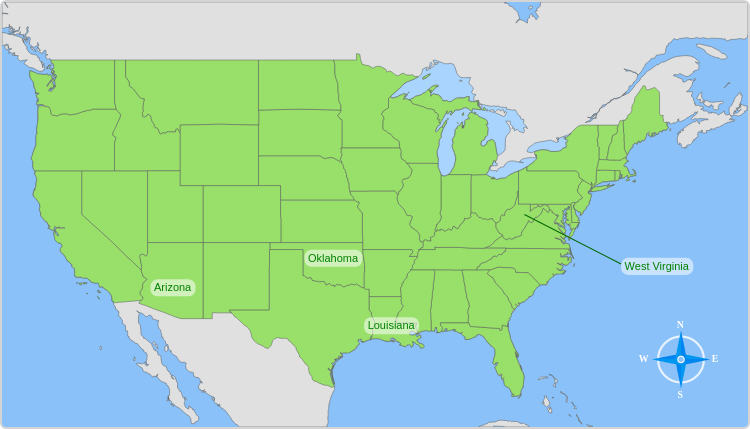

In [3]:
len(sqa_dataset), sqa_dataset[0]
Image.open(sqa_dataset[0][2])

In [4]:
from dataclasses import dataclass
@dataclass
class QaImageOutput:
    q_input_ids: torch.Tensor
    pixel_values: torch.Tensor
    a_input_ids: torch.Tensor

def preprocess_multimodal(q_text: str):
    if DEFAULT_IMAGE_TOKEN in q_text:
        q_text = q_text.replace(DEFAULT_IMAGE_TOKEN, '').strip()
        q_text = DEFAULT_IMAGE_TOKEN + '\n' + q_text
        q_text = q_text.strip()
    return q_text

def build_qaimage(processor: AutoProcessor, q_text: str, a_text: str, image_path: Path) -> QaImageOutput:
    is_multimodal = image_path is not None
    if is_multimodal: # adjust <image> position to the begin for instruction or input or question
        q_text = preprocess_multimodal(q_text)
    else:   # 非多模态数据添加默认的图片占位符，后续将mask掉
        q_text = DEFAULT_IMAGE_TOKEN + q_text
    
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": q_text},
    ]
    # 应用模板后将会应用speaker角色及start/end signal
    prompt = processor.tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    
    # 生成Question部分的向量
    raw_image = None
    inputs = None
    if is_multimodal:  # 若原始数据中有图片, 则读取图片
        raw_image = Image.open(fp=image_path)
        inputs = processor(text=prompt, images=raw_image, return_tensors="pt")
    else:   # 若原始数据中没有图片, 生成一个占位图片，并在后续的处理中通过mask忽略掉占位图片
        crop_size = processor.image_processor.crop_size
        raw_image = torch.zeros(3, crop_size['height'], crop_size['width'])
        inputs = processor(text=prompt, images=raw_image, return_tensors="pt", do_rescale=False)
   
    # 生成Answer部分的向量
    # BEGIN_SIGNAL = '<|im_start|>'
    # END_SIGNAL = '<|im_end|>'
    # a_text = a_text + END_SIGNAL + '\n' + BEGIN_SIGNAL
    a_input_ids = processor.tokenizer(
        a_text,
        return_tensors="pt",
        padding="longest",
        truncation=True,
    )["input_ids"]
    return QaImageOutput(
        q_input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        a_input_ids=a_input_ids
    )

In [5]:
llava_model_name_or_path = "../qwen2.5_3B_Instruct_clipvL14_model/model001"
llava_processor = AutoProcessor.from_pretrained(pretrained_model_name_or_path=llava_model_name_or_path)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
from torch import Tensor
# 定义 collator 函数
class TrainLLavaModelCollator:
    def __init__(self, processor: AutoProcessor, MY_IGNORE_INDEX: int) -> None:
        self.processor = processor
        self.ignore_index = MY_IGNORE_INDEX if MY_IGNORE_INDEX is not None else IGNORE_INDEX

    # 拼接单个样本的 q_input_ids 及 a_input_ids
    def convert_one_piece(self,
                          q_input_ids: torch.Tensor,
                          a_input_ids: torch.Tensor) -> None:
        
        # 滑动窗口寻找'<|im_end|>\n'出现的位置
        def SlidingWindow(q_input_ids: torch.Tensor, STOP_SIGNAL: str) -> List[int]:
            stop_input_ids = self.processor.tokenizer(STOP_SIGNAL, return_tensors="pt")["input_ids"].squeeze()
            indices = []
            for i in range(len(q_input_ids) - 1):
                if q_input_ids[i].item() == stop_input_ids[0].item() and q_input_ids[i+1].item() == stop_input_ids[1].item():
                    indices.append(i)
            return indices

        input_ids = torch.concat(tensors=[
            q_input_ids,
            a_input_ids,
            torch.tensor(data=self.processor.tokenizer.eos_token_id).reshape(1, -1)
        ], axis=1)

        STOP_SIGNAL = '<|im_end|>\n'
        indices = SlidingWindow(q_input_ids=q_input_ids.squeeze(), STOP_SIGNAL=STOP_SIGNAL)
        # FIXME: 目前掩码掉system对话中的STOP_SIGNAL, 但不掩码掉user对话中的STOP_SIGNAL
        indices = indices[1:] # system对话中包含<|im_end|>\n，system对话全ignore

        labels = torch.concat([ # 遵循 llava 源码的写法，不ignore每个对话<STOP>作用的位置
            torch.full_like(input=q_input_ids, fill_value=self.ignore_index),
            a_input_ids,
            torch.tensor(data=self.processor.tokenizer.eos_token_id).reshape(1, -1)
        ], axis=1)
        
        for idx in indices: # <|im_end|>\n位置不掩码，模型学习对话如何结束
            labels[:, idx:idx+2] = q_input_ids[:, idx:idx+2]

        return input_ids, labels
    
    def __call__(self, features:List) -> tuple[Tensor, Tensor, Tensor, Tensor]:
        input_ids_list = []
        labels_list = []
        pixel_values = []
        max_input_len_list = []
        is_multimodal_list = []

        for feature in features:
            # 0. 判断是否为多模态数据
            is_multimodal = feature[2] is not None
            is_multimodal_list.append(is_multimodal)
            # 1. 调用 build_qaimage 函数将单个样本转换为张量
            qaimage_output = build_qaimage(
                processor=self.processor,
                q_text=feature[0],
                a_text=feature[1],
                image_path=feature[2]
            )
            # 2. 将单个样本的 q_input_ids 及 a_input_ids 张量拼接
            temp_input_ids, temp_labels = self.convert_one_piece(
                q_input_ids=qaimage_output.q_input_ids,
                a_input_ids=qaimage_output.a_input_ids,
            )
            # # 避免超过模型最大长进而CUDA OUT OF MEMORY
            # temp_input_ids = temp_input_ids[:, :self.tokenizer_model_max_length]
            # temp_labels = temp_labels[:, :self.tokenizer_model_max_length]

            input_ids_list.append(temp_input_ids)
            labels_list.append(temp_labels)
            pixel_values.append(qaimage_output.pixel_values)
            max_input_len_list.append(temp_input_ids.shape[1])
        
        # 对齐 input_ids 和 labels
        max_input_len = max(max_input_len_list)
        final_input_ids = torch.concat([    # 将所有对齐到最大长度后的 input_ids 拼接起来组成 final_input_ids
            torch.concat([  # 遍历每个 input_ids 将它们对齐到最大长度
                torch.full(size=(1, max_input_len - max_input_len_list[index]), fill_value=self.processor.tokenizer.pad_token_id),
                value
            ], axis=1)
            for index, value in enumerate(iterable=input_ids_list)
        ])

        final_labels = torch.concat([    # 将所有对齐到最大长度后的 labels 拼接起来组成 final_labels
            torch.concat([  # 遍历每个 labels 将它们对齐到最大长度
                torch.full(size=(1, max_input_len - max_input_len_list[index]), fill_value=self.ignore_index),
                value
            ], axis=1)
            for index, value in enumerate(iterable=labels_list)
        ])

        # 按照 dim=0 维拼接所有的 pixel_values
        final_pixel_values = torch.concat(pixel_values, axis=0)
        attention_mask = torch.ones_like(final_input_ids)
        # 因对齐而造成的填充部分 attention_mask 置 0
        attention_mask[final_input_ids == self.processor.tokenizer.pad_token_id] = 0
        for batch_idx, is_multimodal in enumerate(is_multimodal_list):  # 处理非多模态数据的图片占位符
            if not is_multimodal:
                non_multimodal_image_pad_mask = (final_input_ids[batch_idx] == self.processor.tokenizer.encode(DEFAULT_IMAGE_TOKEN)[0])
                non_multimodal_image_pad_mask.to(attention_mask.device)
                attention_mask[batch_idx][non_multimodal_image_pad_mask] = 0    # 将非多模态数据的图片占位位置mask掉
        
        return {
            "input_ids": final_input_ids,
            "labels": final_labels,
            "pixel_values": final_pixel_values,
            "attention_mask": attention_mask
        }

In [7]:
# 定义 collator 函数
class belta_TrainLLavaModelCollator:
    def __init__(self, processor: AutoProcessor, MY_IGNORE_INDEX: int, MY_MODEL_MAX_Q_LENGTH: int, MY_MODEL_MAX_A_LENGTH: int) -> None:
        self.processor = processor
        self.ignore_index = MY_IGNORE_INDEX if MY_IGNORE_INDEX is not None else IGNORE_INDEX
        self.model_max_q_length = MY_MODEL_MAX_Q_LENGTH if MY_MODEL_MAX_Q_LENGTH is not None else MODEL_MAX_Q_LENGTH
        self.model_max_a_length = MY_MODEL_MAX_A_LENGTH if MY_MODEL_MAX_A_LENGTH is not None else MODEL_MAX_A_LENGTH
        self.model_max_length = self.model_max_q_length + self.model_max_a_length

    # 拼接单个样本的 q_input_ids 及 a_input_ids
    def convert_one_piece(self,
                          q_input_ids: torch.Tensor,
                          a_input_ids: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        
        # 滑动窗口寻找'<|im_end|>\n'出现的位置
        def SlidingWindow(q_input_ids: torch.Tensor, STOP_SIGNAL: str) -> List[int]:
            stop_input_ids = self.processor.tokenizer(STOP_SIGNAL, return_tensors="pt")["input_ids"].squeeze()
            indices = []
            for i in range(len(q_input_ids) - 1):
                if q_input_ids[i].item() == stop_input_ids[0].item() and q_input_ids[i+1].item() == stop_input_ids[1].item():
                    indices.append(i)
            return indices

        input_ids = torch.concat(tensors=[
            q_input_ids,
            a_input_ids,
            torch.tensor(data=self.processor.tokenizer.eos_token_id).reshape(1, -1)
        ], axis=1)

        STOP_SIGNAL = '<|im_end|>\n'
        indices = SlidingWindow(q_input_ids=q_input_ids.squeeze(), STOP_SIGNAL=STOP_SIGNAL)
        # FIXME: 目前掩码掉system对话中的STOP_SIGNAL, 但不掩码掉user对话中的STOP_SIGNAL
        indices = indices[1:] # system对话中包含<|im_end|>\n，system对话全ignore

        labels = torch.concat([ # 遵循 llava 源码的写法，不ignore每个对话<STOP>作用的位置
            torch.full_like(input=q_input_ids, fill_value=self.ignore_index),
            a_input_ids,
            torch.tensor(data=self.processor.tokenizer.eos_token_id).reshape(1, -1)
        ], axis=1)
        
        for idx in indices: # <|im_end|>\n位置不掩码，模型学习对话如何结束
            labels[:, idx:idx+2] = q_input_ids[:, idx:idx+2]

        return input_ids, labels
    
    def __call__(self, features:List) -> tuple[Tensor, Tensor, Tensor, Tensor]:
        input_ids_list = []
        labels_list = []
        pixel_values = []
        max_input_len_list = []
        is_multimodal_list = []

        for feature in features:
            # 0. 判断是否为多模态数据
            is_multimodal = feature[2] is not None
            is_multimodal_list.append(is_multimodal)
            # 1. 调用 build_qaimage 函数将单个样本转换为张量
            qaimage_output = build_qaimage(
                processor=self.processor,
                q_text=feature[0],
                a_text=feature[1],
                image_path=feature[2]
            )
            # 2. 将单个样本的 q_input_ids 及 a_input_ids 张量拼接
            temp_input_ids, temp_labels = self.convert_one_piece(
                q_input_ids=qaimage_output.q_input_ids,
                a_input_ids=qaimage_output.a_input_ids,
            )
            
            """
                FIXME: 设计合理的裁剪算法，必须保留q_input_ids和a_input_ids两部分。
                避免超过模型最大长度进而CUDA OUT OF MEMORY且保证labels不全为ignore_index
                为避免<image>占位符后续处理的统计错误, 采取了右截断, 后续可以考虑对a_input_ids进行左截断
            """
            q_input_length = qaimage_output.q_input_ids.shape[1]
            a_input_length = qaimage_output.a_input_ids.shape[1]
            if temp_input_ids.shape[1] - 1 > self.model_max_length: # temp_input_ids末尾有一个eos_token
                if self.model_max_q_length + a_input_length <= self.model_max_length:   # q_input_ids长度过长导致超过model_max_length
                    temp_input_ids = torch.cat((temp_input_ids[:, :self.model_max_q_length], temp_input_ids[:, q_input_length:]), dim=1)
                    temp_labels = torch.cat((temp_labels[:, :self.model_max_q_length], temp_labels[:, q_input_length:]), dim=1)
                elif q_input_length + self.model_max_a_length <= self.model_max_length: # a_input_ids长度过长导致超过model_max_length
                    temp_input_ids = torch.cat((temp_input_ids[:, :q_input_length + self.model_max_a_length], temp_input_ids[:, -1:]), dim=1)
                    temp_labels = torch.cat((temp_labels[:, :q_input_length + self.model_max_a_length], temp_labels[:, -1:]), dim=1)
                else:       # q_input_ids和a_input_ids长度都过长导致超过model_max_length
                    temp_input_ids = torch.cat((temp_input_ids[:, :self.model_max_q_length], temp_input_ids[:, q_input_length:q_input_length + self.model_max_a_length], temp_input_ids[:, -1:]), dim=1)
                    temp_labels = torch.cat((temp_labels[:, :self.model_max_q_length], temp_labels[:, q_input_length:q_input_length + self.model_max_a_length], temp_labels[:, -1:]), dim=1)

            input_ids_list.append(temp_input_ids)
            labels_list.append(temp_labels)
            pixel_values.append(qaimage_output.pixel_values)
            max_input_len_list.append(temp_input_ids.shape[1])
        
        # 对齐 input_ids 和 labels
        max_input_len = max(max_input_len_list)
        final_input_ids = torch.concat([    # 将所有对齐到最大长度后的 input_ids 拼接起来组成 final_input_ids
            torch.concat([  # 遍历每个 input_ids 将它们对齐到最大长度
                torch.full(size=(1, max_input_len - max_input_len_list[index]), fill_value=self.processor.tokenizer.pad_token_id),
                value
            ], axis=1)
            for index, value in enumerate(iterable=input_ids_list)
        ])

        final_labels = torch.concat([    # 将所有对齐到最大长度后的 labels 拼接起来组成 final_labels
            torch.concat([  # 遍历每个 labels 将它们对齐到最大长度
                torch.full(size=(1, max_input_len - max_input_len_list[index]), fill_value=self.ignore_index),
                value
            ], axis=1)
            for index, value in enumerate(iterable=labels_list)
        ])

        # 按照 dim=0 维拼接所有的 pixel_values
        final_pixel_values = torch.concat(pixel_values, axis=0)
        attention_mask = torch.ones_like(final_input_ids)
        # 因对齐而造成的填充部分 attention_mask 置 0
        attention_mask[final_input_ids == self.processor.tokenizer.pad_token_id] = 0
        for batch_idx, is_multimodal in enumerate(is_multimodal_list):  # 处理非多模态数据的图片占位符
            if not is_multimodal:
                non_multimodal_image_pad_mask = (final_input_ids[batch_idx] == self.processor.tokenizer.encode(DEFAULT_IMAGE_TOKEN)[0])
                non_multimodal_image_pad_mask.to(attention_mask.device)
                attention_mask[batch_idx][non_multimodal_image_pad_mask] = 0    # 将非多模态数据的图片占位位置mask掉
        
        return {
            "input_ids": final_input_ids,
            "labels": final_labels,
            "pixel_values": final_pixel_values,
            "attention_mask": attention_mask
        }

In [25]:
tlmc = TrainLLavaModelCollator(llava_processor, -100)
belta_tlmc = belta_TrainLLavaModelCollator(llava_processor, -100, 768, 512)
c = build_qaimage(processor=llava_processor, q_text=sqa_dataset[887][0], a_text=sqa_dataset[887][1], image_path=sqa_dataset[887][2])
c.q_input_ids.shape, c.a_input_ids.shape, c.pixel_values.shape
c.a_input_ids[0][511]

tensor(19)

In [12]:
e = belta_tlmc([sqa_dataset[887]])
e['input_ids'].shape, e['labels'].shape, e['pixel_values'].shape, e['attention_mask'].shape

(torch.Size([1, 1281]),
 torch.Size([1, 1281]),
 torch.Size([1, 3, 336, 336]),
 torch.Size([1, 1281]))

In [23]:
e['input_ids'][0][-2]

tensor(19)

In [ ]:
one_piece = tlmc.convert_one_piece(c.q_input_ids, c.a_input_ids)
# d = tlmc([sqa_dataset[0], sqa_dataset[100]])
one_piece

In [ ]:
d = tlmc([sqa_dataset[0], sqa_dataset[1]])
d['input_ids'].shape, d['labels'].shape, d['pixel_values'].shape, d['attention_mask'].shape

In [ ]:
d['attention_mask'][0]

In [ ]:
from transformers import AutoProcessor, LlavaForConditionalGeneration
llava_model_name_or_path = "../qwen2.5_3B_Instruct_clipvL14_model/model001"
llava_model = LlavaForConditionalGeneration.from_pretrained(pretrained_model_name_or_path=llava_model_name_or_path,
                                                            torch_dtype=torch.bfloat16,
                                                            device_map='cuda:0')

In [ ]:
for tk in d.keys():
    d[tk] = d[tk].to(device='cuda')
model_output = llava_model(**d)

In [ ]:
model_output.keys()

In [ ]:
model_output['loss']

In [ ]:
chat_file = "/d/lsy/shared_data/liuhaotian/LLaVA-Finetune/ScienceQA/llava_train_QCM-LEA.json"
# 读取json文件
chat_data = pd.read_json(path_or_buf=chat_file)
chat_data.shape
chat_data.head(n=20)
# 将dataframe数据类型转换为字典
cc = chat_data.to_dict(orient="records")
cc

In [ ]:
# 计算每个对话拼接后的最大字符串长度
max_length = 0
over_length_count = 0
for item in cc:
    try:
        # 获取第一个和第二个对话的 value
        convo_1_value = item['conversations'][0]['value']
        convo_2_value = item['conversations'][1]['value']
        # 拼接两个 value 并计算长度
        combined_length = len(convo_1_value + convo_2_value)
        # 更新最大长度
        max_length = max(max_length, combined_length)
        if combined_length > 1368:
            over_length_count += 1
    except (IndexError, KeyError):
        # 如果某些条目格式不正确，跳过
        continue

print(f"最长字符串的长度是: {max_length}")
print(f"超过1024长度的对话有: {over_length_count} 条")